In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore",category= DeprecationWarning)
warnings.filterwarnings("ignore")
import random
from sklearn import  metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression,Lasso , Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score

In [2]:
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [3]:
#train
target_col = ["target"]
id_dataset = ["id"]
#numerical columns
num_cols   = [x for x in train_df.columns if x not in target_col + id_dataset]

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(train_df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_data_og = train_df.copy()
data = train_df.drop(columns = num_cols,axis = 1)
data = data.merge(scaled,left_index=True,right_index=True,how = "left")
data = data.drop(columns = ['id'],axis = 1)

#test 
target_col = ["target"]
id_dataset = ["id"]
#numerical columns
num_cols   = [x for x in test_df.columns if x not in target_col + id_dataset]

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(test_df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_test_og = test_df.copy()
test = test_df.drop(columns = num_cols,axis = 1)
test = test.merge(scaled,left_index=True,right_index=True,how = "left")
test = test.drop(columns = ['id'],axis = 1)

In [4]:
#### Check correlation and drop ####

corr_matrix = pd.DataFrame(data)

corr = corr_matrix.corr().abs()
corr = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
print(corr.head(5))

#### Also check correlation to target variable ####
cor_t = pd.DataFrame(data).apply(lambda x: x.corr(data.target)).abs().sort_values(ascending=False)
print(cor_t.head(5))

target  33     0.373608
        65     0.293846
32      75     0.259315
101     193    0.252825
22      28     0.246062
dtype: float64
target    1.000000
33        0.373608
65        0.293846
217       0.207215
117       0.197496
dtype: float64


In [5]:
# Def X and Y

#data = data.sample(frac=1)

x = data.drop('target', 1)
y = data['target']

seed = 12

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state=seed)

sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

#x_train, x_test, y_train, y_test= train_test_split(x, y, test_size=.2, random_state=seed)

In [6]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=25, random_state=seed)
clf_rf.fit(x_train_res, y_train_res)

print('Validation Results')
print(clf_rf.score(x_val, y_val))
print(recall_score(y_val, clf_rf.predict(x_val)))
print(clf_rf.score(x, y))
print(recall_score(y, clf_rf.predict(x)))

pred = clf_rf.predict_proba(test)
print('pred: ',pred)

model_score = cross_val_score(clf_rf, x, y, cv=10, )
print('cv scores: ',model_score)
print('avg of the cv scores: ',model_score.mean().round(4))
print('stdev of the cv scores: ',model_score.std().round(4))

prediction = pd.DataFrame(clf_rf.predict_proba(x)).drop(columns = 0, axis = 1)
print('ROC_AUC is: ',roc_auc_score(y, prediction).round(4))
print('Sum of probabilites: ',sum(pred))
#print(logreg.coef_)

Validation Results
0.62
0.7857142857142857
0.924
0.9625
pred:  [[0.44 0.56]
 [0.24 0.76]
 [0.44 0.56]
 ...
 [0.56 0.44]
 [0.36 0.64]
 [0.56 0.44]]
cv scores:  [0.68 0.64 0.6  0.68 0.64 0.64 0.68 0.56 0.72 0.56]
avg of the cv scores:  0.64
stdev of the cv scores:  0.0506
ROC_AUC is:  0.9836
Sum of probabilites:  [ 8159.48 11590.52]


In [7]:
logreg=LogisticRegression(random_state=seed)
param_grid={ 'class_weight': ['balanced', None],
              'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'solver' : ['liblinear'],
              'penalty':['l1','l2']
           }
grid=GridSearchCV(logreg, param_grid = param_grid , scoring = 'roc_auc', verbose = 1, n_jobs = -1)
grid.fit(x,y)

print('Best Score: ', grid.best_score_)
print('Best Parameters: ', grid.best_params_)

logreg = LogisticRegression(random_state = seed, 
                             C = .1, class_weight = 'balanced',
                             penalty = 'l1', solver = 'liblinear')
logreg.fit(x_train_res,y_train_res)
pred = logreg.predict_proba(test)
print('pred: ',pred)

model_score = cross_val_score(logreg, x_train_res, y_train_res, cv=10,scoring='roc_auc' )
print('cv scores: ',model_score)
print('avg of the cv scores: ',model_score.mean().round(4))
print('stdev of the cv scores: ',model_score.std().round(4))

prediction = pd.DataFrame(logreg.predict_proba(x_train_res)).drop(columns = 0, axis = 1)
print('ROC_AUC is: ',roc_auc_score(y_train_res, prediction).round(4))
print('Sum of probabilites: ',sum(pred))
#print(logreg.coef_)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  69 out of  84 | elapsed:    5.0s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    5.1s finished
C:\Users\balod\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Score:  0.8069269042627533
Best Parameters:  {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
pred:  [[0.50014807 0.49985193]
 [0.41717814 0.58282186]
 [0.27595924 0.72404076]
 ...
 [0.74214748 0.25785252]
 [0.08625468 0.91374532]
 [0.68912924 0.31087076]]
cv scores:  [0.80612245 0.95918367 0.77514793 0.81065089 0.95857988 0.9408284
 0.94674556 1.         1.         0.9704142 ]
avg of the cv scores:  0.9168
stdev of the cv scores:  0.0808
ROC_AUC is:  0.9827
Sum of probabilites:  [ 9223.61832321 10526.38167679]


In [8]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
logreg = LogisticRegression(random_state = seed, 
                             C = .1, class_weight = 'balanced',
                             penalty = 'l1', solver = 'liblinear')
abc = AdaBoostClassifier(base_estimator=LogisticRegression(random_state=seed),random_state=seed)

abc.fit(x_train_res,y_train_res)
pred = abc.predict_proba(test)
print('pred: ',pred)

model_score = cross_val_score(abc, x_train_res, y_train_res, cv=10,scoring='roc_auc' )
print('cv scores: ',model_score)
print('avg of the cv scores: ',model_score.mean().round(4))
print('stdev of the cv scores: ',model_score.std().round(4))

prediction = pd.DataFrame(abc.predict_proba(x_train_res)).drop(columns = 0, axis = 1)
print('ROC_AUC is: ',roc_auc_score(y_train_res, prediction).round(4))
print('Sum of probabilites: ',sum(pred))
#print(logreg.coef_)

pred:  [[0.47744549 0.52255451]
 [0.5430961  0.4569039 ]
 [0.44294279 0.55705721]
 ...
 [0.4438645  0.5561355 ]
 [0.34842724 0.65157276]
 [0.44154912 0.55845088]]
cv scores:  [0.87755102 0.75510204 0.87573964 0.83431953 0.8816568  0.97633136
 0.98224852 0.97633136 1.         0.96449704]
avg of the cv scores:  0.9124
stdev of the cv scores:  0.076
ROC_AUC is:  1.0
Sum of probabilites:  [ 9543.23835087 10206.76164913]


In [9]:
from sklearn.svm import LinearSVC

model = LinearSVC(random_state=seed)
param_grid={'C':[0.001, 0.01, 0.1, 1, 10],
            #'penalty':['l1','l2']
           }
grid=GridSearchCV(model, param_grid = param_grid , scoring = 'roc_auc', verbose = 1, n_jobs = -1)
grid.fit(x,y)

print('Best Score: ', grid.best_score_)
print('Best Parameters: ', grid.best_params_)

model = LinearSVC(random_state = seed, C = .001,)
model.fit(x,y)
pred = model.predict(test)
print('pred: ',pred)

model_score = cross_val_score(model, x, y, cv=10, )
print('cv scores: ',model_score)
print('avg of the cv scores: ',model_score.mean().round(4))
print('stdev of the cv scores: ',model_score.std().round(4))

prediction = pd.DataFrame(model.predict(x))
print('ROC_AUC is: ',roc_auc_score(y, prediction).round(4))
print('Sum of probabilites: ',sum(pred))
#print(logreg.coef_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Score:  0.6989196366177498
Best Parameters:  {'C': 0.001}
pred:  [1. 0. 0. ... 1. 1. 0.]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished
C:\Users\balod\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


cv scores:  [0.76 0.6  0.6  0.64 0.8  0.56 0.64 0.64 0.68 0.68]
avg of the cv scores:  0.66
stdev of the cv scores:  0.0699
ROC_AUC is:  0.9844
Sum of probabilites:  12378.0


LR 	 cv mean:  0.7887 	 cv std:  12.9 % 	 AUC:  1.0 	 Accuracy:  1.0
LDA 	 cv mean:  0.6355 	 cv std:  15.1 % 	 AUC:  1.0 	 Accuracy:  1.0
KNN 	 cv mean:  0.6546 	 cv std:  17.49 % 	 AUC:  0.65 	 Accuracy:  0.72
TREE 	 cv mean:  0.605 	 cv std:  15.6 % 	 AUC:  1.0 	 Accuracy:  1.0
NB 	 cv mean:  0.725 	 cv std:  12.24 % 	 AUC:  0.9851 	 Accuracy:  0.984
SVM 	 cv mean:  0.7962 	 cv std:  12.93 % 	 AUC:  1.0 	 Accuracy:  1.0
LIN 	 cv mean:  0.7942 	 cv std:  12.2 % 	 AUC:  1.0 	 Accuracy:  1.0
SIG 	 cv mean:  0.7836 	 cv std:  14.26 % 	 AUC:  0.8375 	 Accuracy:  0.876
POLY 	 cv mean:  0.7225 	 cv std:  17.7 % 	 AUC:  1.0 	 Accuracy:  1.0
BAG 	 cv mean:  0.6308 	 cv std:  17.04 % 	 AUC:  0.9913 	 Accuracy:  0.992
QDA 	 cv mean:  0.5755 	 cv std:  12.370000000000001 % 	 AUC:  1.0 	 Accuracy:  1.0
RF 	 cv mean:  0.5956 	 cv std:  22.28 % 	 AUC:  0.9944 	 Accuracy:  0.996
ADA 	 cv mean:  0.7891 	 cv std:  13.700000000000001 % 	 AUC:  0.9938 	 Accuracy:  0.992
GBC 	 cv mean:  0.7349 	 cv std:

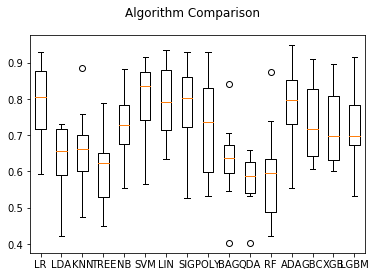

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
import xgboost
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn import model_selection

models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier(n_neighbors= 20)))
models.append(('TREE', DecisionTreeClassifier(random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))
models.append(('LIN',SVC(random_state=seed,kernel='linear')))
models.append(('SIG',SVC(random_state=seed,kernel='sigmoid')))
models.append(('POLY',SVC(random_state=seed,kernel='poly')))
models.append(('BAG',BaggingClassifier()))
models.append(('QDA',QuadraticDiscriminantAnalysis()))
models.append(('RF', RandomForestClassifier(random_state=seed)))
models.append(('ADA', AdaBoostClassifier(base_estimator=LogisticRegression(random_state=seed))))
models.append(('GBC', GradientBoostingClassifier(random_state=seed)))
models.append(('XGB', xgboost.XGBClassifier()))
models.append(('LGBM', LGBMClassifier()))

seed = 9

results = []
names = []
scoring = 'roc_auc'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, x, y, cv=kfold, scoring=scoring)
    model.fit(x,y)
    pred = model.predict(test)
    prediction = pd.DataFrame(model.predict(x))
    results.append(cv_results.round(4))
    names.append(name)
    roc_auc = roc_auc_score(y, prediction).round(4)
    rel_std = cv_results.std()/cv_results.mean()
    accuracy = accuracy_score(y, prediction)
    print(name,'\t cv mean: ',cv_results.mean().round(4), 
          '\t cv std: ',rel_std.round(4)*100,'%',
          '\t AUC: ',roc_auc,
         '\t Accuracy: ',accuracy)

    # boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [11]:
!pip install lightgbm

In [12]:
selector = abc

submission = pd.read_csv('submission.csv')
final_test = test
submission['target'] = selector.predict_proba(final_test)
submission.to_csv('submission.csv', index=False)